In [334]:
#!pip install PyWavelets # -> for PyWavelets
#!pip install git+https://github.com/laszukdawid/PyEMD.git # for CEEDMAN Algorithm
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt as wt
from PyEMD import EMD, EEMD, CEEMDAN
from PyEMD.checks import whitenoise_check
from IPython.display import Image, display, HTML

## 0. Some Helper Functions

In [249]:
def get_denoised_signal(noisy_signal, wavelet, threshold_mode, level):
    coeffs = wt.wavedec(noisy_signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(noisy_signal)))
    coeffs_thresh = [wt.threshold(c, threshold, mode=threshold_mode) for c in coeffs]
    denoised_signal = wt.waverec(coeffs_thresh, wavelet)

    return denoised_signal

def get_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(clean_signal - denoised_signal))
    max_value = np.max(clean_signal)
    psnr = 10 * np.log10(max_value ** 2 / mse)

    metrics_dict = {"mse":mse, "rmse": rmse, "mae":mae, "psnr":psnr}
    return metrics_dict

def simulate_stock_price(initial_price, drift, volatility, time_horizon, time_increment):
    num_steps = int(time_horizon / time_increment)
    time_points = np.arange(0, time_horizon, time_increment)
    stock_prices = np.zeros(num_steps)
    stock_prices[0] = initial_price
    
    for i in range(1, num_steps):
        random_increment = np.random.normal(drift * time_increment, volatility * np.sqrt(time_increment))
        stock_prices[i] = stock_prices[i - 1] * np.exp(random_increment)
    
    return time_points, stock_prices

def print_metrics(metrics_s, metrics_h):
    return pd.DataFrame([metrics_s, metrics_h],  index=['metrics_s', 'metrics_h']).T


## 1. Generate a Synthetic Noisy Signal

In [2]:
t = np.linspace(0, 1, 1000)             # time vector
clean_signal = np.sin(2*np.pi*5*t)      # clean sine wave signal with a frequency of 5 Hz
noise = 0.5*np.random.randn(1000)       # Gaussian Noise ~ N(0,0.5)
noisy_signal = clean_signal + noise     # noisy signal 

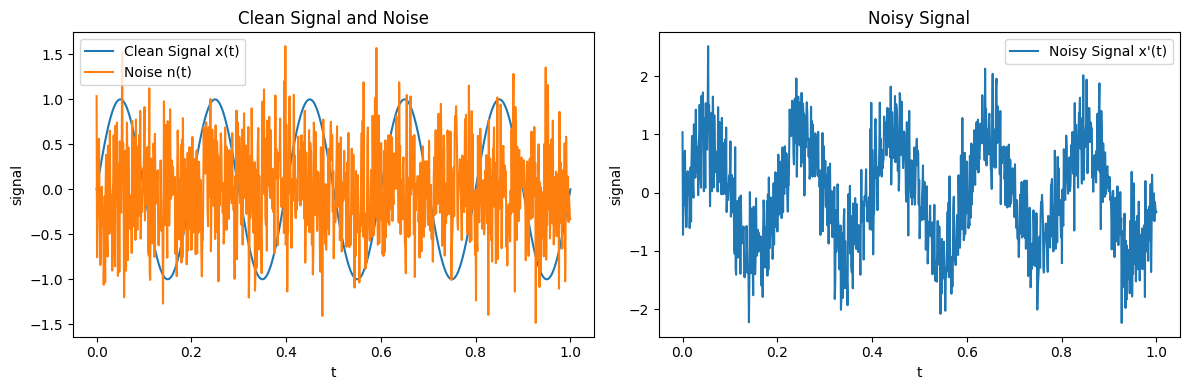

In [24]:
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(12,4))


# clean signal and noise
ax1.plot(t, clean_signal, label="Clean Signal x(t)")
ax1.plot(t, noise, label='Noise n(t)')
ax1.set_title("Clean Signal and Noise")
ax1.set_xlabel("t")
ax1.set_ylabel("signal")
ax1.legend()

# noisy signal
ax2.plot(t, noisy_signal, label="Noisy Signal x'(t)")
ax2.set_title("Noisy Signal")
ax2.set_xlabel("t")
ax2.set_ylabel("signal")
ax2.legend()

plt.tight_layout()
plt.legend()
plt.show()


## 2. Perform the Wavelet Decomposition

In [27]:
# list of wavelet families available:
for family in wt.families():
    print("%s family: " % family + ', '.join(wt.wavelist(family)))

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

In [34]:
chosen_families = ['haar', 'db1', 'db4', 'dmey']

In [100]:
# let us perform the decomposition using one of the families
wavelet = chosen_families[2]
coeffs4 = wt.wavedec(noisy_signal, wavelet, level=4)
ca4, cd4, cd3, cd2, cd1 = coeffs4

In [125]:
image_path = "images/level4_diagram.png"
# Image(filename=image_path, width=1000, height=200)
display(HTML(f'<div style="text-align:center;"><img src="{image_path}" width="1000" height="500"></div>'))

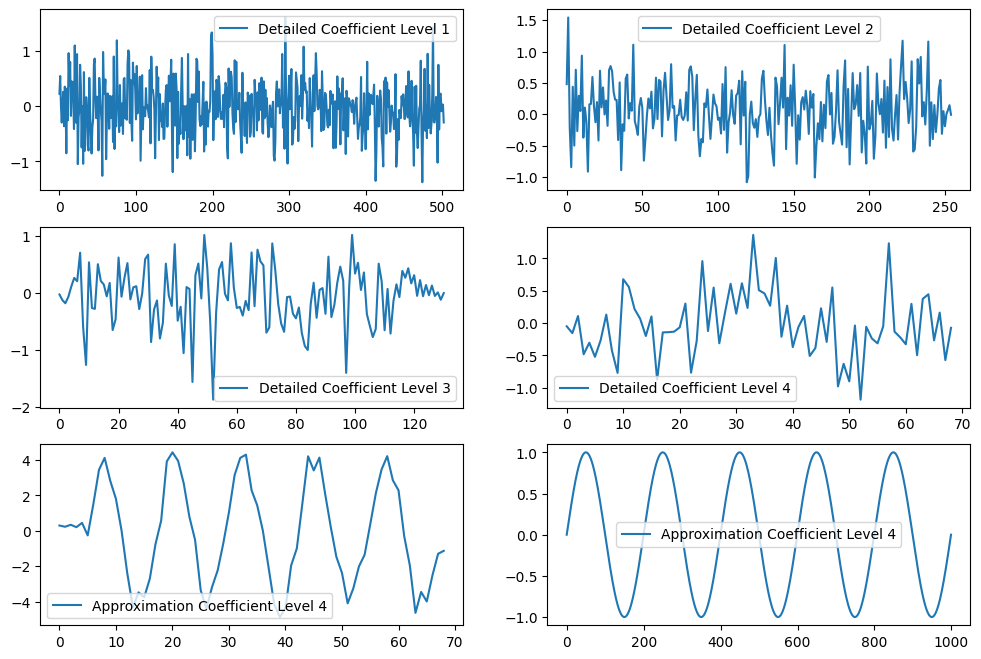

In [115]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) =  plt.subplots(3,2, figsize=(12, 8))

ax1.plot(cd1, label="Detailed Coefficient Level 1")
ax1.legend()

ax2.plot(cd2, label="Detailed Coefficient Level 2")
ax2.legend()

ax3.plot(cd3, label="Detailed Coefficient Level 3")
ax3.legend()

ax4.plot(cd4, label="Detailed Coefficient Level 4")
ax4.legend()

ax5.plot(ca4, label="Approximation Coefficient Level 4")
ax5.legend()

ax6.plot(clean_signal, label="Approximation Coefficient Level 4")
ax6.legend()

## 3. Thresholding

In [82]:
threshold4 = np.std(coeffs4[-1]) * np.sqrt(2 * np.log(len(noisy_signal)))
coeffs_thresh4s = [wt.threshold(c, threshold4, mode='soft') for c in coeffs4]
coeffs_thresh4h = [wt.threshold(c, threshold4, mode='hard') for c in coeffs4]

## 4. Reconstructing the Denoised Signal

In [83]:
denoised_signal4s = wt.waverec(coeffs_thresh4s, wavelet)
denoised_signal4h = wt.waverec(coeffs_thresh4h, wavelet)

## 5. Plotting and Analyzing the Result

In [136]:
# soft thresholding
mse_s = np.mean((clean_signal - denoised_signal4s) ** 2)
rmse_s = np.sqrt(mse_s)
mae_s = np.mean(np.abs(clean_signal - denoised_signal4s))
max_value = np.max(clean_signal)
psnr_s = 10 * np.log10(max_value ** 2 / mse_s)

# hard thresholding
mse_h = np.mean((clean_signal - denoised_signal4h) ** 2)
rmse_h = np.sqrt(mse_h)
mae_h = np.mean(np.abs(clean_signal - denoised_signal4h))
psnr_h = 10 * np.log10(max_value ** 2 / mse_h)

# print the results
index_values = ["MSE", "RMSE", "MAE", "PSNR"]
df = pd.DataFrame(index=index_values)
df["soft"] = [mse_s, rmse_s, mae_s, psnr_s]
df["hard"] = [mse_h, rmse_h, mae_h, psnr_h]
print(df)

          soft       hard
MSE   0.164641   0.041016
RMSE  0.405760   0.202523
MAE   0.369887   0.156303
PSNR  7.834597  13.870487


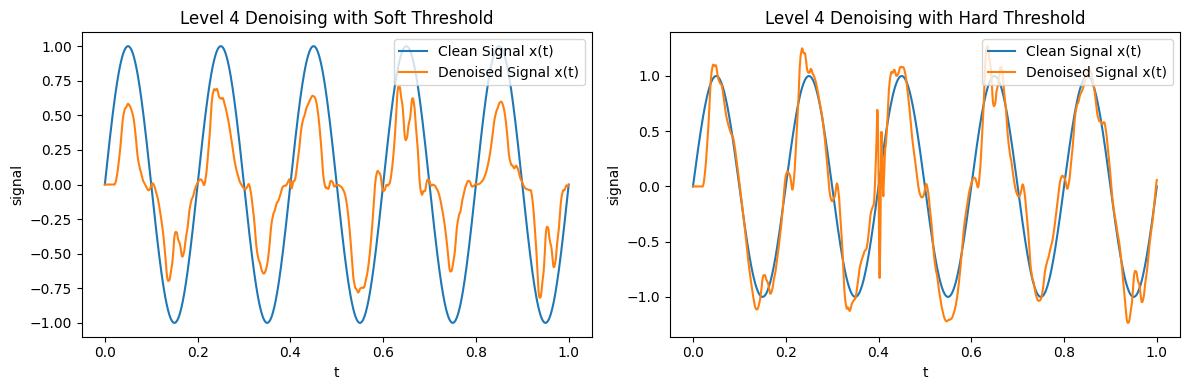

In [86]:
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(12, 4))


# level 1 
ax1.plot(t, clean_signal, label="Clean Signal x(t)")
ax1.plot(t, denoised_signal4s, label="Denoised Signal x(t)")
ax1.set_title("Level 4 Denoising with Soft Threshold")
ax1.set_xlabel("t")
ax1.set_ylabel("signal")
ax1.legend()

# level 2
ax2.plot(t, clean_signal, label="Clean Signal x(t)")
ax2.plot(t, denoised_signal4h, label="Denoised Signal x(t)")
ax2.set_title("Level 4 Denoising with Hard Threshold")
ax2.set_xlabel("t")
ax2.set_ylabel("signal")
ax2.legend()

plt.tight_layout()
plt.legend()
plt.show()


## 6. Wavelet Based Denoising of Synthetic Minutely-Data (generated using GBM)

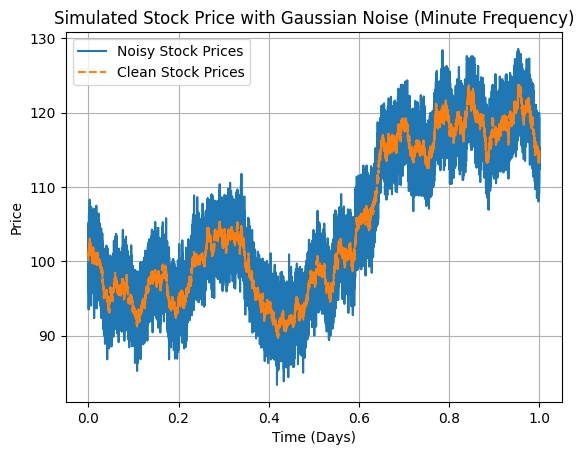

In [219]:
# Parameters
initial_price = 100.0           # initial stock price
drift = 0.05                    # drift (expected retur!)
volatility = 0.2                # volatility (standard deviation of returns)
time_horizon = 1.0              # time horizon (in years)
time_increment = 1/(252*390)    # time frequency (minutely tickers)

# Simulate stock price
time_points, clean_stock_prices = simulate_stock_price(initial_price, drift, volatility, time_horizon, time_increment)

# Add Gaussian noise
noise_stddev = 2.0  # Standard deviation of Gaussian noise
noise = np.random.normal(0, noise_stddev, len(clean_stock_prices))
noisy_stock_prices = clean_stock_prices + noise

# Plot the simulated stock prices
plt.plot(time_points, noisy_stock_prices, label='Noisy Stock Prices')
plt.plot(time_points, clean_stock_prices, label='Clean Stock Prices', linestyle='--')
plt.title('Simulated Stock Price with Gaussian Noise (Minute Frequency)')
plt.xlabel('Time (Days)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [242]:
ds_s = get_denoised_signal(noisy_signal=noisy_stock_prices,
                            wavelet='sym4', 
                            threshold_mode='soft', 
                            level=4)
metrics_s = get_metrics(clean_signal=clean_stock_prices, 
                        denoised_signal=ds_s)
ds_h = get_denoised_signal(noisy_signal=noisy_stock_prices,
                            wavelet='sym4',
                            threshold_mode='hard', 
                            level=4)
metrics_h = get_metrics(clean_signal=clean_stock_prices, 
                        denoised_signal=ds_h)

print_metrics(metrics_s, metrics_h)

,metrics_s,metrics_h
mse,6.040729,0.255255
rmse,2.457789,0.505228
mae,2.405304,0.397780
psnr,34.044552,47.785703


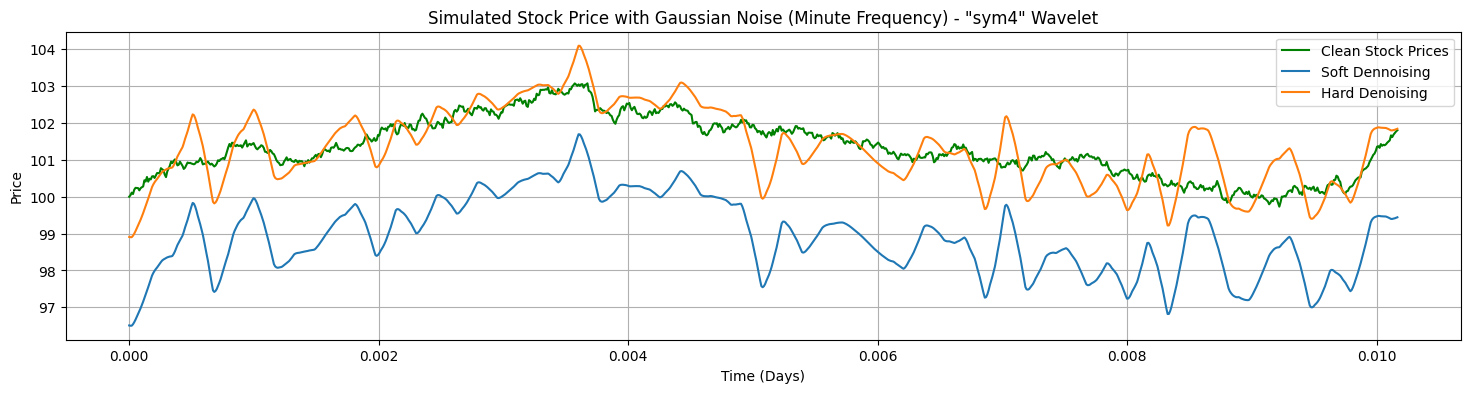

In [246]:
n = 1000
plt.figure(figsize=(18, 4))
plt.plot(time_points[0:n], clean_stock_prices[0:n], label='Clean Stock Prices',color="green")
plt.plot(time_points[0:n], ds_s[0:n], label='Soft Dennoising')
plt.plot(time_points[0:n], ds_h[0:n], label='Hard Denoising')
plt.title('Simulated Stock Price with Gaussian Noise (Minute Frequency) - "sym4" Wavelet')
plt.xlabel('Time (Days)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 7. EMD - Empirical Mode Decomposition

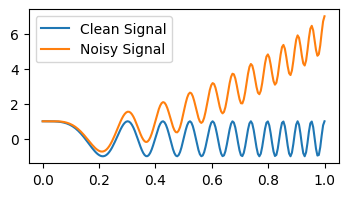

In [342]:
# Define signal
t = np.linspace(0, 1, 200)

t = np.linspace(0, 1, 200)
s = np.cos(11*2*np.pi*t*t) + 6*t*t

plt.figure(figsize=(4, 2))
plt.plot(t, np.cos(11*2*np.pi*t*t), label="Clean Signal")
plt.plot(t, s, label="Noisy Signal")
plt.legend()
plt.show()

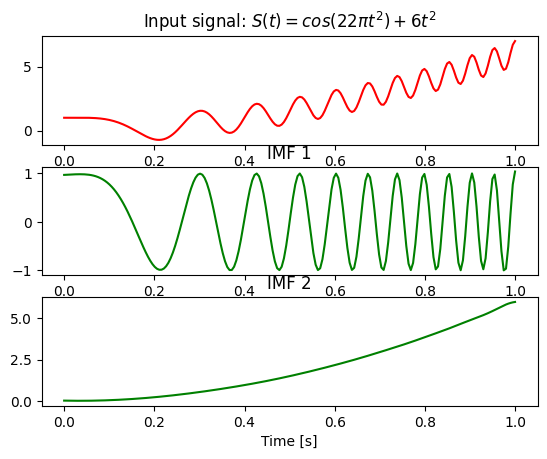

In [345]:
# perform emd on the noisy signal
emd = EMD()
IMF = EMD().emd(s,t)
N = IMF.shape[0]+1

# plot results
plt.subplot(N,1,1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")
plt.show()

### 7.1 EMD on Stock Prices

In [324]:
n = 500
time_points = time_points[0:n]
signal = noisy_stock_prices[0:n]

IMF_stock = EMD().emd(signal, time_points)
N = IMF_stock.shape[0]+1

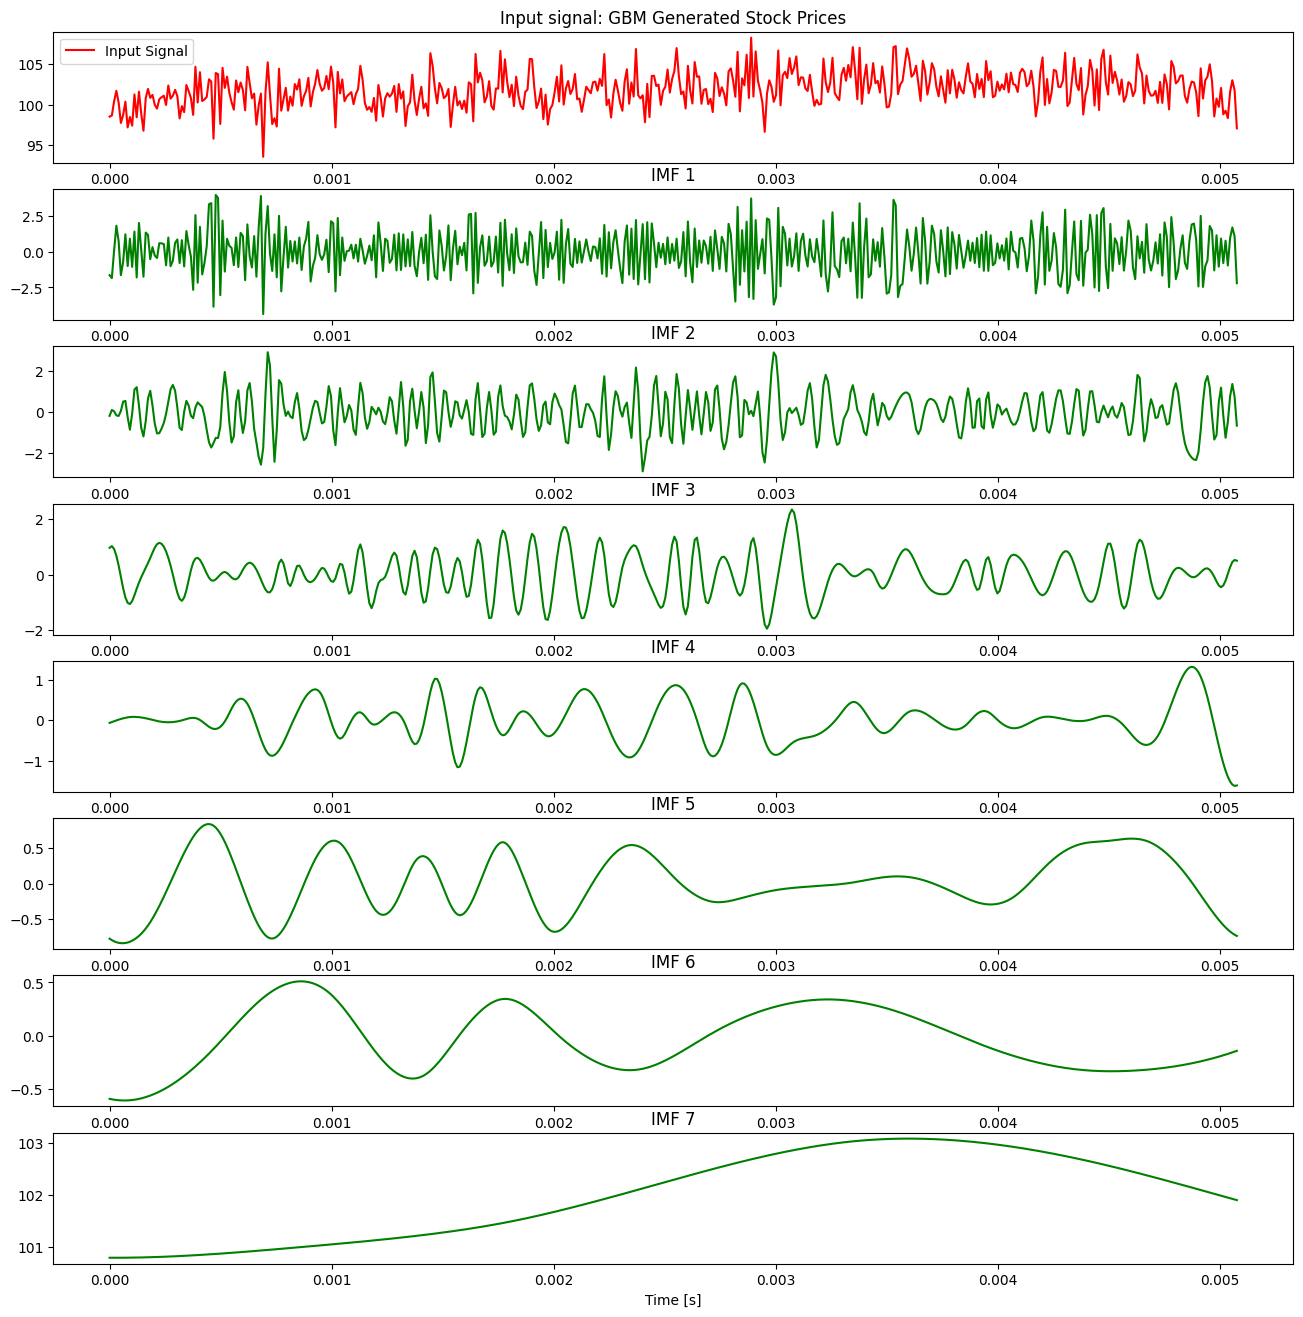

In [325]:
# plot results
plt.figure(figsize=(16, 16))
plt.subplot(N,1,1)
plt.plot(time_points, signal, 'r', label='Input Signal')
plt.title("Input signal: GBM Generated Stock Prices")
plt.xlabel("Time [s]")
plt.legend()

for n, imf in enumerate(IMF_stock):
    plt.subplot(N,1,n+2)
    plt.plot(time_points, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

In [314]:
# check for white-noise
significant_imfs = whitenoise_check(IMF_stock, test_name='apriori')

## 8. EEMD - Ensemble Empirical Mode Decomposition

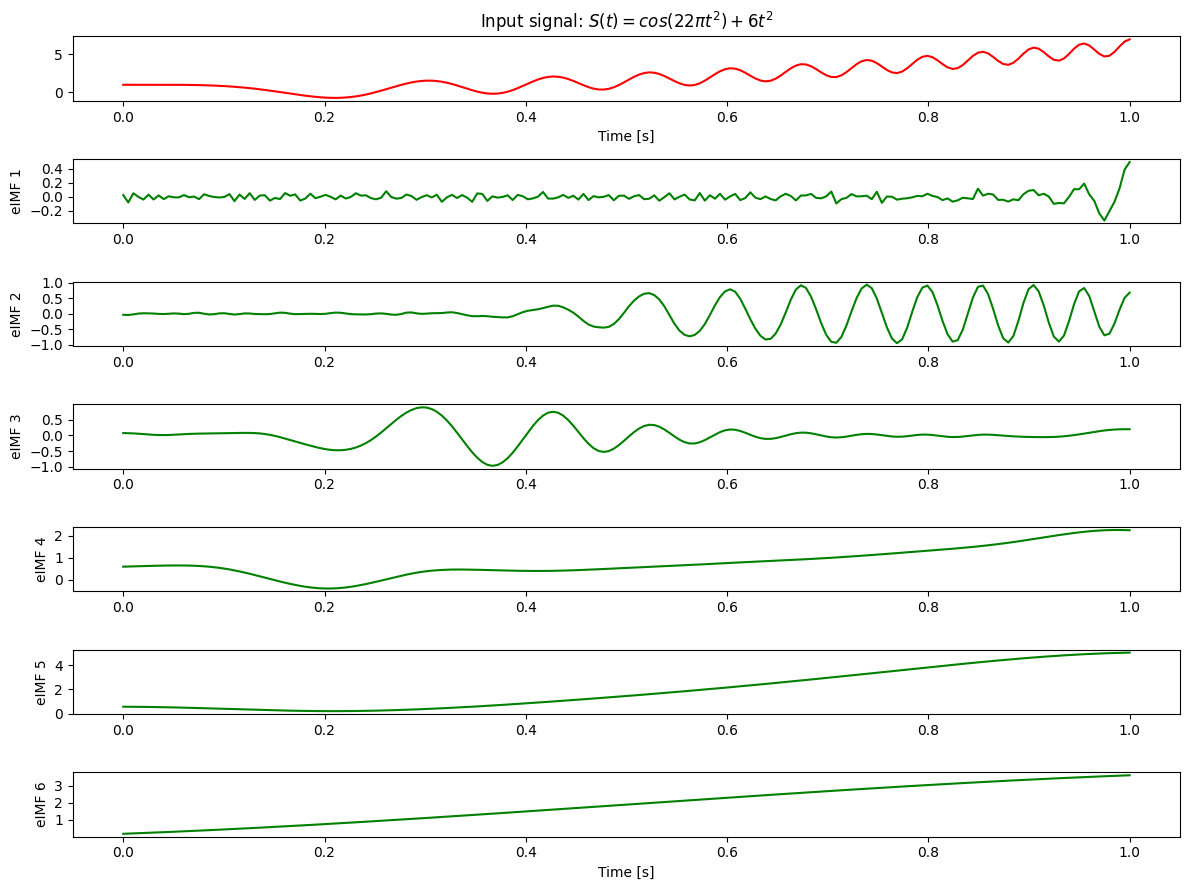

In [319]:
# perform emd on the noisy signal
eemd = EEMD()

# detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"

# Execute EEMD on s
eIMF = eemd.eemd(s,t)
nIMF = eIMF.shape[0]

# plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMF+1, 1, 1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n in range(nIMF):
    plt.subplot(nIMF+1, 1, n+2)
    plt.plot(t, eIMF[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

### 2.1 EEMD on Stock Prices

In [322]:
numElements = 500
time_points = time_points[0:numElements]
signal = noisy_stock_prices[0:numElements]

eIMF_stock = eemd.eemd(signal, time_points)
nEIMF = eIMF_stock.shape[0]+1

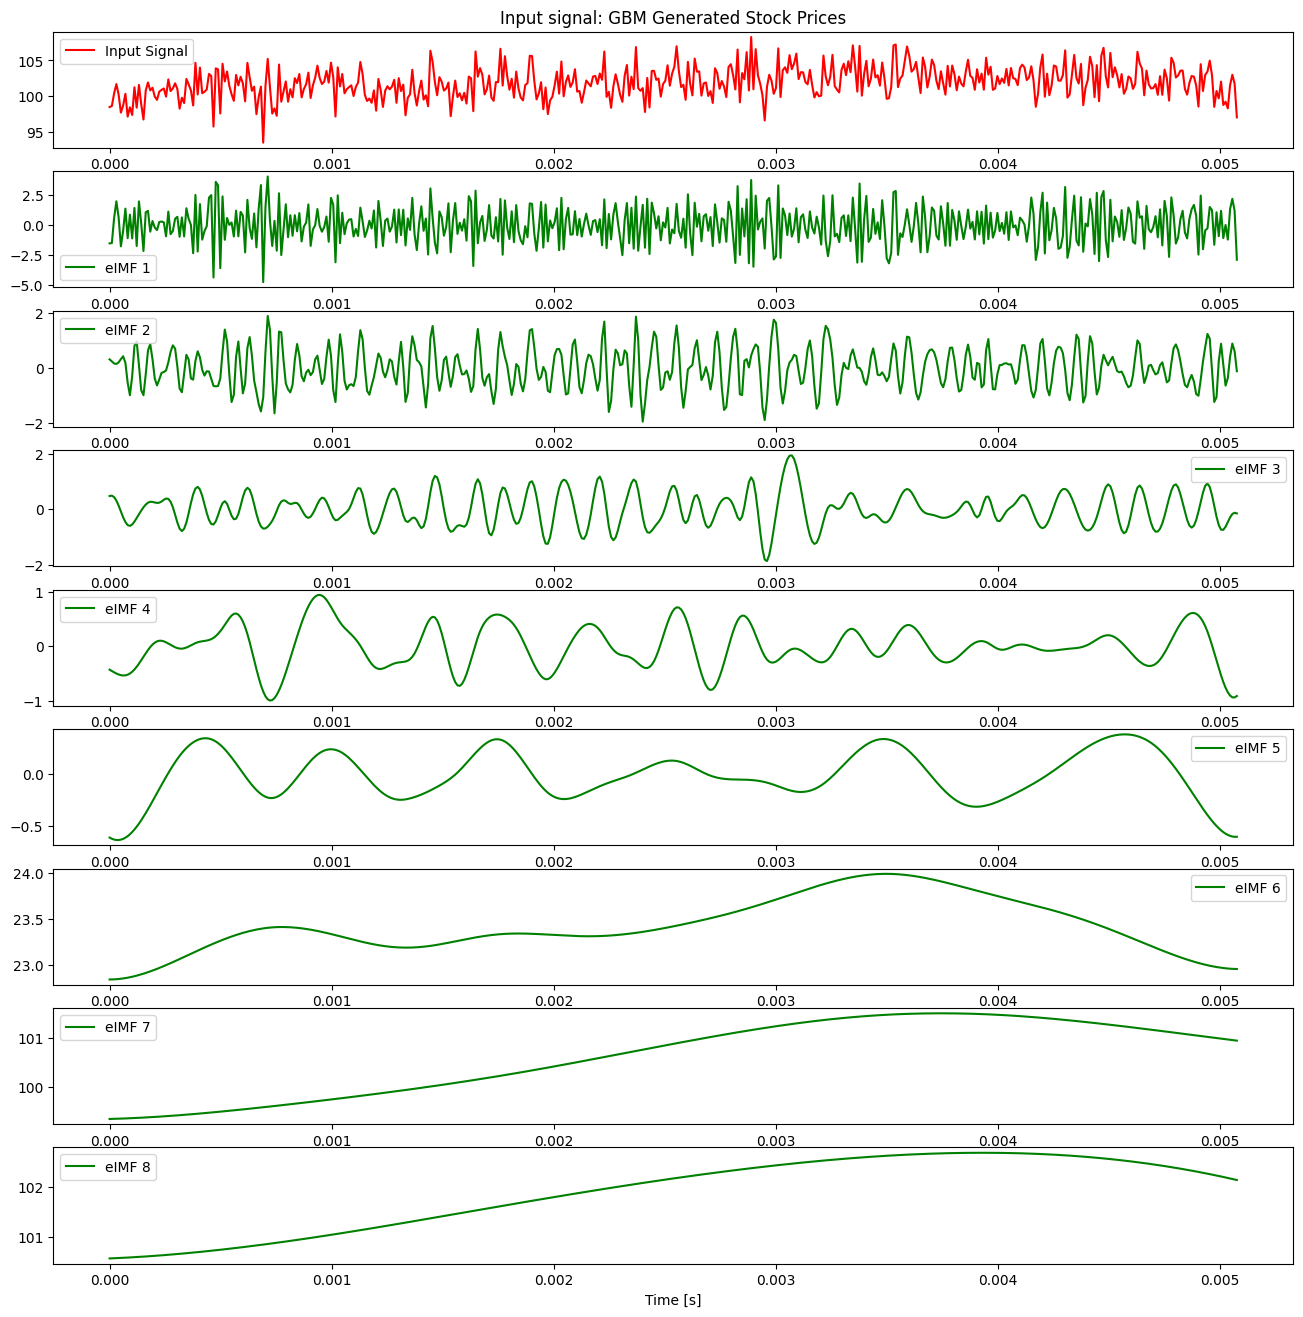

In [327]:
# plot results
plt.figure(figsize=(16, 16))
plt.subplot(nEIMF,1,1)
plt.plot(time_points, signal, 'r', label='Input Signal')
plt.title("Input signal: GBM Generated Stock Prices")
plt.xlabel("Time [s]")
plt.legend()

for n, eimf in enumerate(eIMF_stock):
    plt.subplot(nEIMF,1,n+2)
    plt.plot(time_points, eimf, 'g', label=f'eIMF {n+1}')
    # plt.title("eIMF "+str(n+1))
    plt.xlabel("Time [s]")
    plt.legend()

## 9. CEEMDAN - Complete Ensemble Empirical Mode Decomposition with Adaptive Noise

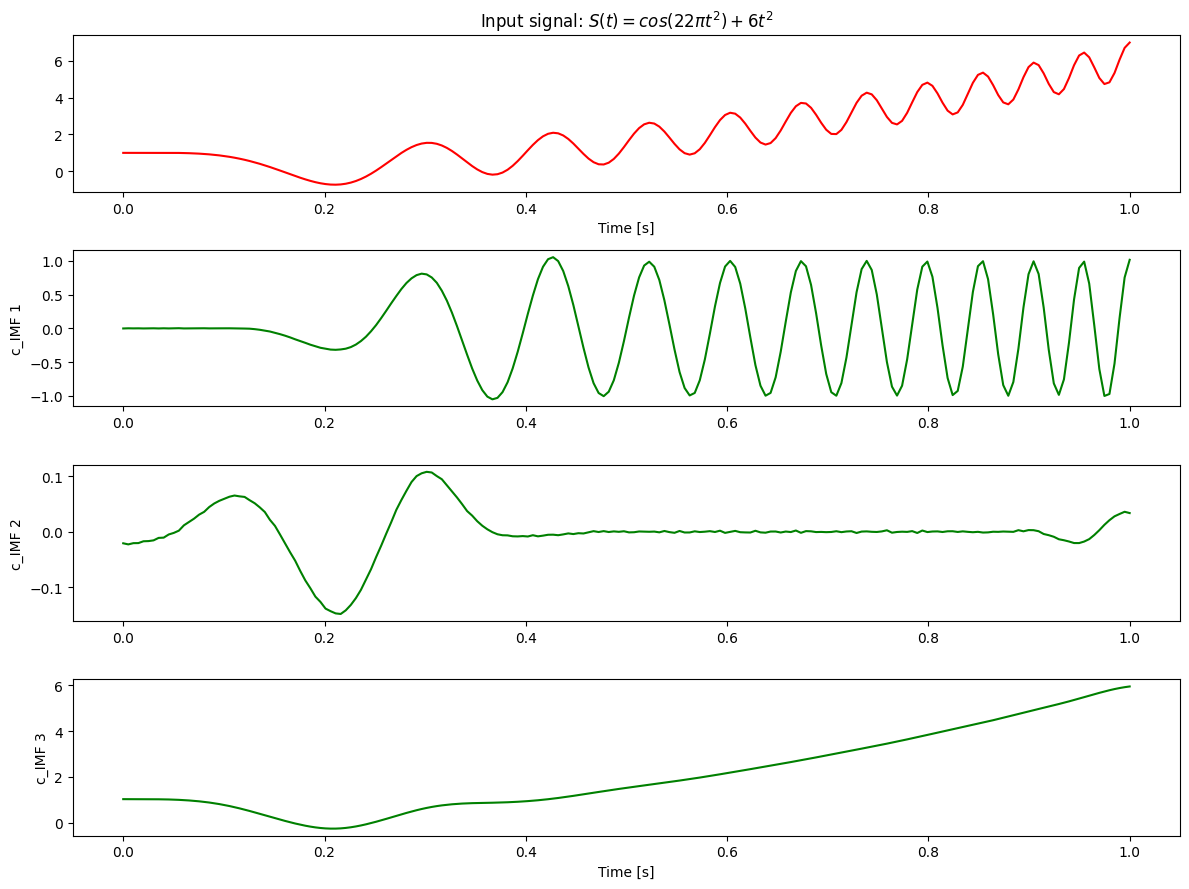

In [338]:
# Execute EEMD on s
ceemdan = CEEMDAN()
c_IMF = ceemdan(s)
nCIMF = c_IMF.shape[0]

# plot results
plt.figure(figsize=(12,9))
plt.subplot(nCIMF+1, 1, 1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n in range(nCIMF):
    plt.subplot(nCIMF+1, 1, n+2)
    plt.plot(t, c_IMF[n], 'g')
    plt.ylabel("c_IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

### 9.1 CEEMDAN on Stock Prices

In [340]:
numElements = 500
time_points = time_points[0:numElements]
signal = noisy_stock_prices[0:numElements]

cIMF_stock = ceemdan(signal)
nCIMF = cIMF_stock.shape[0]+1

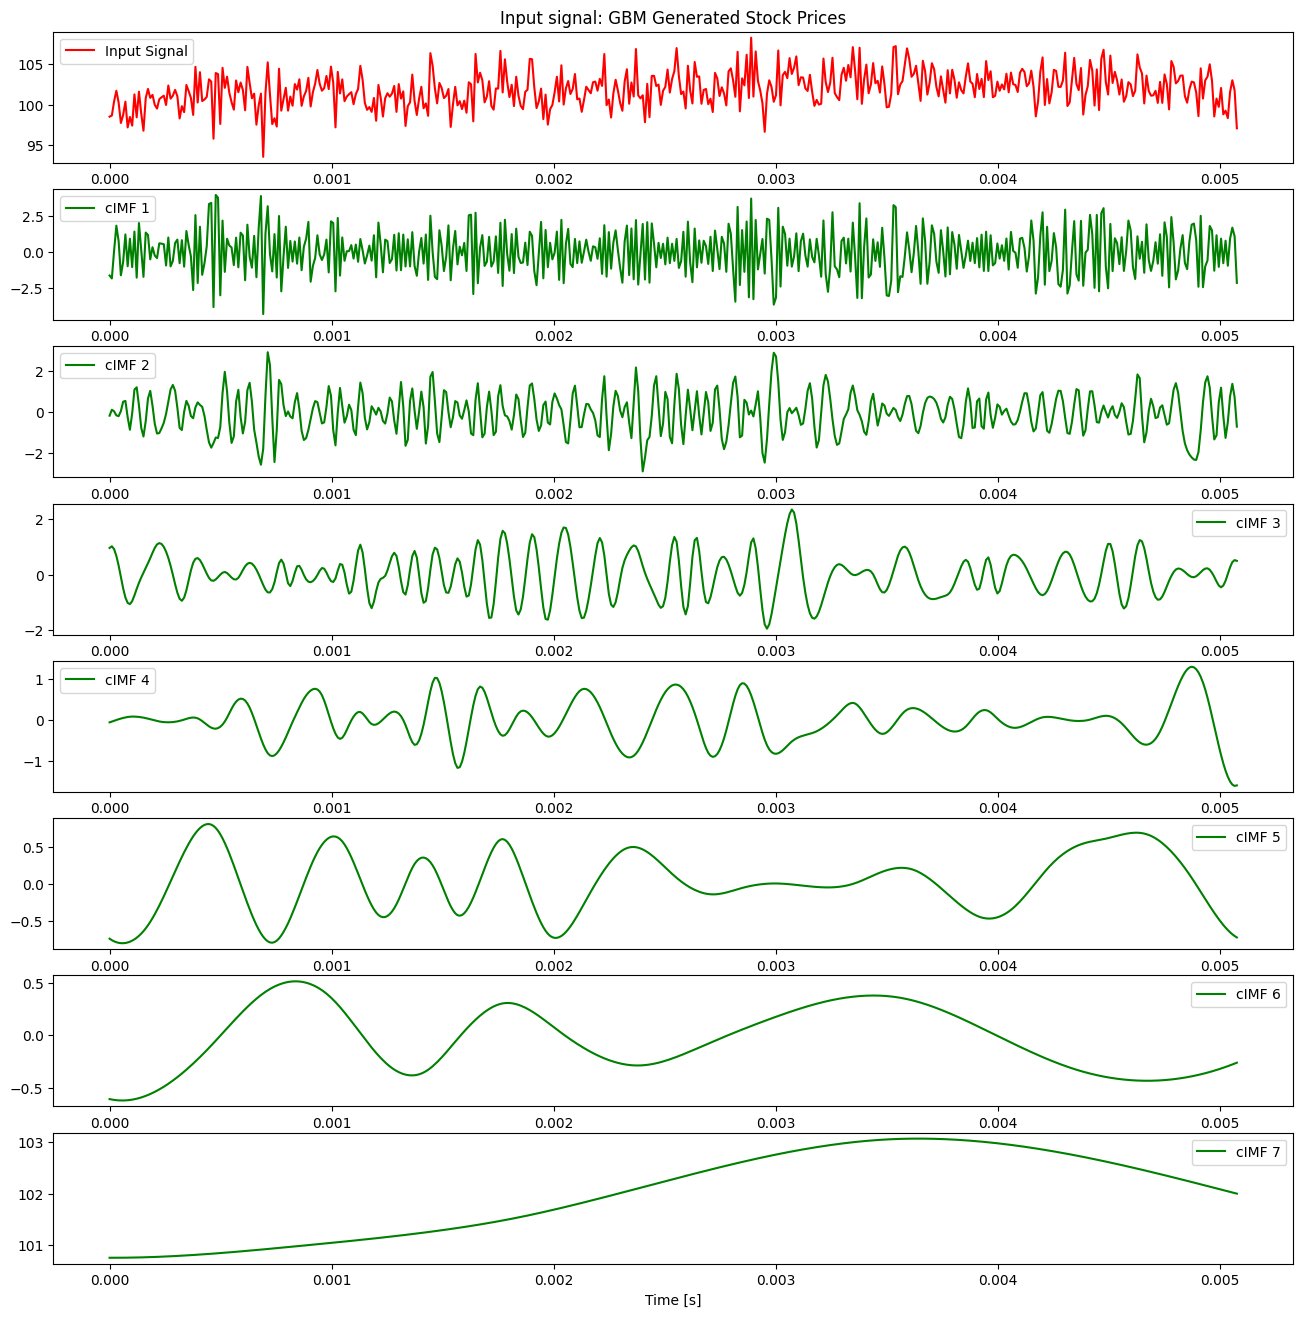

In [341]:
# plot results
plt.figure(figsize=(16, 16))
plt.subplot(nEIMF,1,1)
plt.plot(time_points, signal, 'r', label='Input Signal')
plt.title("Input signal: GBM Generated Stock Prices")
plt.xlabel("Time [s]")
plt.legend()

for n, cimf in enumerate(cIMF_stock):
    plt.subplot(nCIMF,1,n+2)
    plt.plot(time_points, cimf, 'g', label=f'cIMF {n+1}')
    # plt.title("cIMF "+str(n+1))
    plt.xlabel("Time [s]")
    plt.legend()

## 10.ICEEMDAN - Improved Complete Ensemble Empirical Mode Decomposition with Adaptive Noise